# Missingness Pattern Analysis
## Media Freedom Alerts Dataset

This notebook analyzes missingness patterns (MCAR, MAR, MNAR) in the dataset.

---

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load the dataset
df = pd.read_csv('mapmf_alerts_cleaned_null.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (11305, 22)

First few rows:


,id,title,date,year,month,day_of_week,country,region_level_1,region_level_2,primary_incident_type,incident_type_count,type_of_incident,primary_source,source_of_incident,context_of_incident,region_names,content,content_length,published_at_date,_geo_lat,_geo_lng,eu_status
0,34388,Journalist Emilia Șercan targeted with smear c...,2026-01-12,2026,1,Monday,Romania,Romania,Bucharest,Intimidation/threatening,4,Intimidation/threatening | Verbal attack | Dis...,Media outlet,Media outlet | Legislation: government/public ...,Online/digital,EU Member States | Romania | Bucharest,"On 12 January 2026, investigative journalist E...",1740,2026-01-15,44.436141,26.102684,EU Member States
1,34382,OCCRP website targeted with DDoS attack,2026-01-12,2026,1,Monday,Netherlands,Netherlands,North Holland,Hacking/DDoS,5,Hacking/DDoS | Attack to property | Blocked di...,Unknown source of incident,Unknown source of incident,Online/digital,EU Member States | Netherlands | North Holland,"On 13 January 2026, the Organised Crime and Co...",1019,2026-01-14,52.373080,4.892453,EU Member States
2,34358,Slovak political commentator Peter Schutz viol...,2026-01-10,2026,1,Saturday,Slovakia,Slovakia,Eastern Slovakia,Injury (physical assault resulting in injury),2,Injury (physical assault resulting in injury) ...,Unknown source of incident,Unknown source of incident,Public place/street,EU Member States | Slovakia | Eastern Slovakia...,"On 10 January 2025, Slovak political commentat...",2401,2026-01-12,48.717227,21.249677,EU Member States
3,34392,Ici Nord Sylvain Charley cyber harassed,2026-01-08,2026,1,Thursday,France,France,Hauts-de-France,"Harassment, insult, bullying",2,"Harassment, insult, bullying | Verbal attack",Private individual(s),Private individual(s),Online/digital,EU Member States | France | Hauts-de-France | ...,"On 8 January 2026, Sylvain Charley, a journali...",1045,2026-01-16,50.636565,3.063528,EU Member States
4,34356,Police opens investigation into alleged survei...,2026-01-08,2026,1,Thursday,Ukraine,Ukraine,Київська міська громада,Surveillance and interception of journalistic ...,2,Surveillance and interception of journalistic ...,Private individual(s),Private individual(s),Online/digital,EU candidate countries | Ukraine | Київська мі...,"On 8 January 2026, Ukrainian authorities repor...",1865,2026-01-12,50.450034,30.524136,EU Candidate Countries


## 3. Basic Missing Data Summary

In [3]:
# Calculate missing data
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})

# Filter to only columns with missing data
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

print("Variables with Missing Data:")
print("="*80)
missing_data

Variables with Missing Data:


,Column,Missing_Count,Missing_Percentage,Data_Type
context_of_incident,context_of_incident,4797,42.43,object
primary_source,primary_source,165,1.46,object
source_of_incident,source_of_incident,165,1.46,object
region_level_2,region_level_2,131,1.16,object
primary_incident_type,primary_incident_type,99,0.88,object
type_of_incident,type_of_incident,99,0.88,object


## 4. Test for MCAR vs MAR

We use chi-square tests to determine if missingness is related to other variables.
- **MCAR (Missing Completely At Random)**: Missingness is independent of all variables
- **MAR (Missing At Random)**: Missingness depends on observed variables
- **MNAR (Missing Not At Random)**: Missingness depends on unobserved values

In [4]:
# Test if context_of_incident missingness depends on other variables
def test_mcar_vs_mar(df, target_var, test_var):
    """Perform chi-square test for independence."""
    df_temp = df.copy()
    df_temp[f'{target_var}_missing'] = df_temp[target_var].isnull().astype(int)
    
    contingency = pd.crosstab(
        df_temp[test_var].fillna('Missing'), 
        df_temp[f'{target_var}_missing']
    )
    
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        print(f"\n{test_var}:")
        print(f"  Chi-square: {chi2:.4f}")
        print(f"  P-value: {p_value:.4e}")
        print(f"  Significant? {'YES - Reject MCAR' if p_value < 0.05 else 'NO'}")
        
        # Show missing rates
        props = pd.crosstab(
            df_temp[test_var].fillna('Missing'), 
            df_temp[f'{target_var}_missing'], 
            normalize='index'
        )
        print(f"  Missing rate by {test_var}:")
        display(props[1].sort_values(ascending=False).head())
    
# Test multiple variables
print("="*80)
print("TESTING: Does context_of_incident missingness depend on other variables?")
print("="*80)

test_vars = ['year', 'country', 'primary_incident_type', 'eu_status']
for var in test_vars:
    test_mcar_vs_mar(df, 'context_of_incident', var)

TESTING: Does context_of_incident missingness depend on other variables?

year:
  Chi-square: 10370.4931
  P-value: 0.0000e+00
  Significant? YES - Reject MCAR
  Missing rate by year:


year
2016    0.974063
2015    0.956962
2017    0.956403
2018    0.949393
2014    0.926655
Name: 1, dtype: float64


country:
  Chi-square: 2284.5513
  P-value: 0.0000e+00
  Significant? YES - Reject MCAR
  Missing rate by country:


country
Vatican City    1.000000
Iceland         1.000000
Azerbaijan      1.000000
Russia          0.974227
Belarus         0.962199
Name: 1, dtype: float64


primary_incident_type:
  Chi-square: 4718.0969
  P-value: 0.0000e+00
  Significant? YES - Reject MCAR
  Missing rate by primary_incident_type:


primary_incident_type
Missing                                                                                  1.000000
Blocked journalistic activity                                                            0.966601
Physical assault                                                                         0.924749
Article was significantly changed, cut, or framed, which altered its original meaning    0.921260
Attack to property                                                                       0.896341
Name: 1, dtype: float64


eu_status:
  Chi-square: 1286.3497
  P-value: 1.3480e-278
  Significant? YES - Reject MCAR
  Missing rate by eu_status:


eu_status
Non-EU Countries          0.913823
Unknown                   0.463415
EU Candidate Countries    0.371679
EU Member States          0.363496
Name: 1, dtype: float64

## 5. Temporal Pattern Analysis

Context of Incident Missing % by Year:
year
2014    92.665474
2015    95.696203
2016    97.406340
2017    95.640327
2018    94.939271
2019    83.720930
2020     0.000000
2021     0.000000
2022     0.000000
2023     0.000000
2024     0.000000
2025     0.000000
2026     0.000000
Name: context_of_incident, dtype: float64


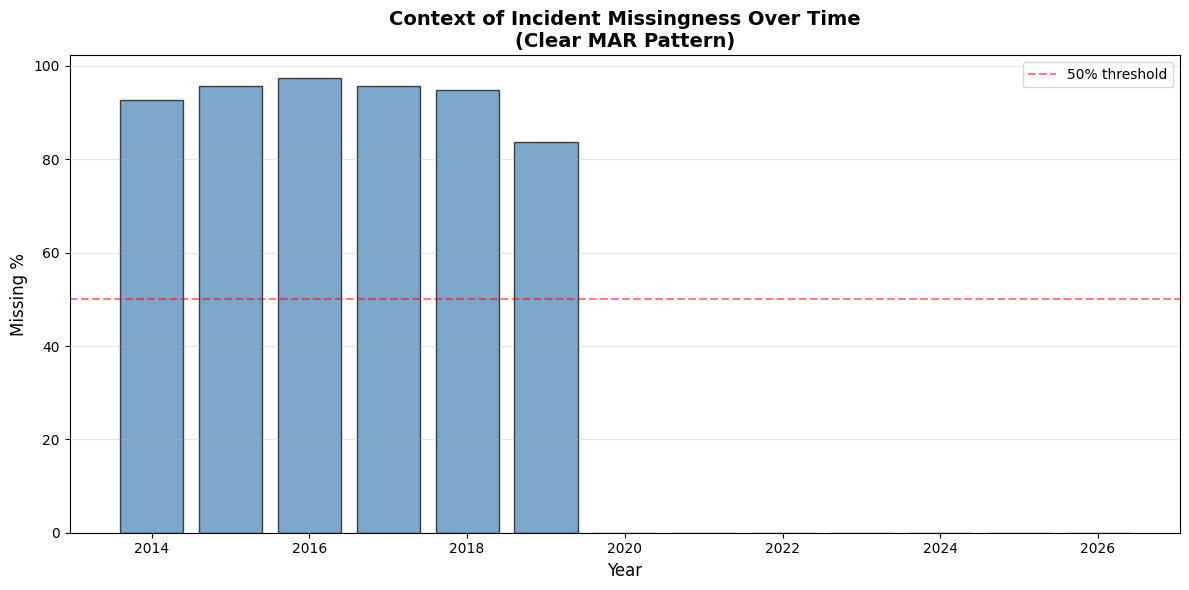


⚠️ INTERPRETATION:
95-97% missing before 2020, 0% missing from 2020 onwards.
This represents a clear data collection policy change (MAR pattern).


In [5]:
# Analyze context_of_incident missingness over time
missing_by_year = df.groupby('year')['context_of_incident'].apply(
    lambda x: x.isnull().sum() / len(x) * 100
)

print("Context of Incident Missing % by Year:")
print(missing_by_year)

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(missing_by_year.index, missing_by_year.values, 
        color='steelblue', alpha=0.7, edgecolor='black')
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Missing %', fontsize=12)
plt.title('Context of Incident Missingness Over Time\n(Clear MAR Pattern)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ INTERPRETATION:")
print("95-97% missing before 2020, 0% missing from 2020 onwards.")
print("This represents a clear data collection policy change (MAR pattern).")

## 6. Co-Missingness Analysis

In [6]:
# Check if variables are always missing together
def analyze_co_missingness(df, var1, var2):
    both_missing = (df[var1].isnull() & df[var2].isnull()).sum()
    only_var1 = (df[var1].isnull() & df[var2].notna()).sum()
    only_var2 = (df[var1].notna() & df[var2].isnull()).sum()
    neither = (df[var1].notna() & df[var2].notna()).sum()
    
    print(f"\n{var1} & {var2}:")
    print(f"  Both missing: {both_missing} ({both_missing/len(df)*100:.2f}%)")
    print(f"  Only {var1} missing: {only_var1}")
    print(f"  Only {var2} missing: {only_var2}")
    print(f"  Neither missing: {neither}")
    
    corr = df[[var1, var2]].isnull().astype(int).corr().iloc[0, 1]
    print(f"  Missingness correlation: {corr:.4f}")
    
    if corr == 1.0:
        print("  → PERFECT CO-MISSINGNESS (structural issue)")
    elif corr > 0.5:
        print("  → STRONG CO-MISSINGNESS")

print("="*80)
print("CO-MISSINGNESS ANALYSIS")
print("="*80)

analyze_co_missingness(df, 'primary_source', 'source_of_incident')
analyze_co_missingness(df, 'primary_incident_type', 'type_of_incident')

CO-MISSINGNESS ANALYSIS

primary_source & source_of_incident:
  Both missing: 165 (1.46%)
  Only primary_source missing: 0
  Only source_of_incident missing: 0
  Neither missing: 11140
  Missingness correlation: 1.0000
  → PERFECT CO-MISSINGNESS (structural issue)

primary_incident_type & type_of_incident:
  Both missing: 99 (0.88%)
  Only primary_incident_type missing: 0
  Only type_of_incident missing: 0
  Neither missing: 11206
  Missingness correlation: 1.0000
  → PERFECT CO-MISSINGNESS (structural issue)


## 7. Geographic Pattern Analysis

Region Level 2 Missing % by Country (top 15):
country
Vatican City       100.000000
Moldova            100.000000
Denmark             52.272727
Slovenia            15.686275
Romania              0.000000
Malta                0.000000
Montenegro           0.000000
Netherlands          0.000000
North Macedonia      0.000000
Norway               0.000000
Poland               0.000000
Portugal             0.000000
Serbia               0.000000
Russia               0.000000
Lithuania            0.000000
Name: region_level_2, dtype: float64


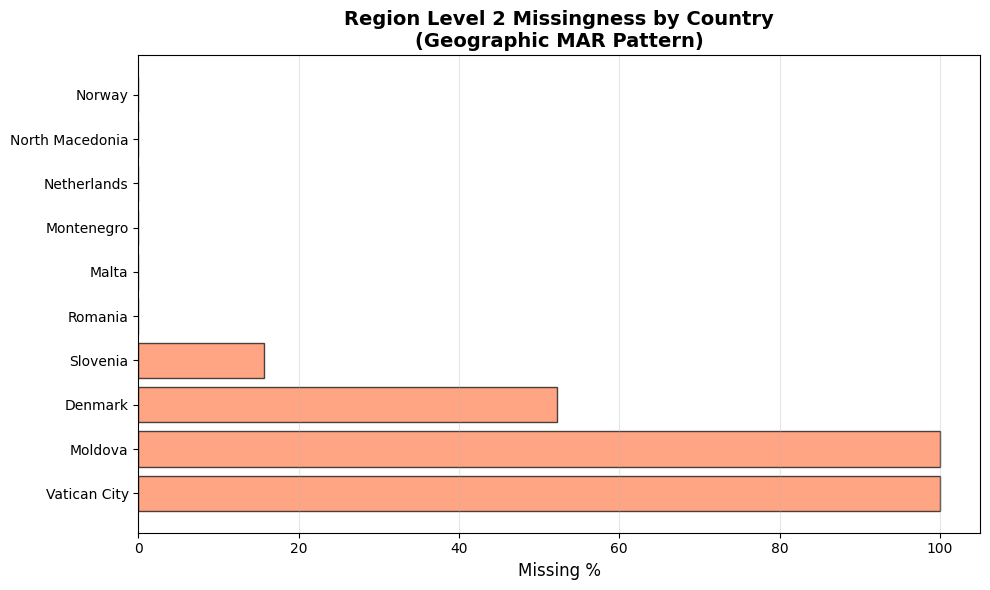


⚠️ INTERPRETATION:
Some countries have 100% missing (Moldova, Vatican City).
This suggests different administrative structures (MAR pattern).


In [7]:
# Analyze region_level_2 missingness by country
region_missing = df.groupby('country')['region_level_2'].apply(
    lambda x: x.isnull().mean() * 100
).sort_values(ascending=False)

print("Region Level 2 Missing % by Country (top 15):")
print(region_missing.head(15))

# Visualize top 10
plt.figure(figsize=(10, 6))
top10 = region_missing.head(10)
plt.barh(range(len(top10)), top10.values, color='coral', alpha=0.7, edgecolor='black')
plt.yticks(range(len(top10)), top10.index)
plt.xlabel('Missing %', fontsize=12)
plt.title('Region Level 2 Missingness by Country\n(Geographic MAR Pattern)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ INTERPRETATION:")
print("Some countries have 100% missing (Moldova, Vatican City).")
print("This suggests different administrative structures (MAR pattern).")

## 8. Missingness Correlation Matrix

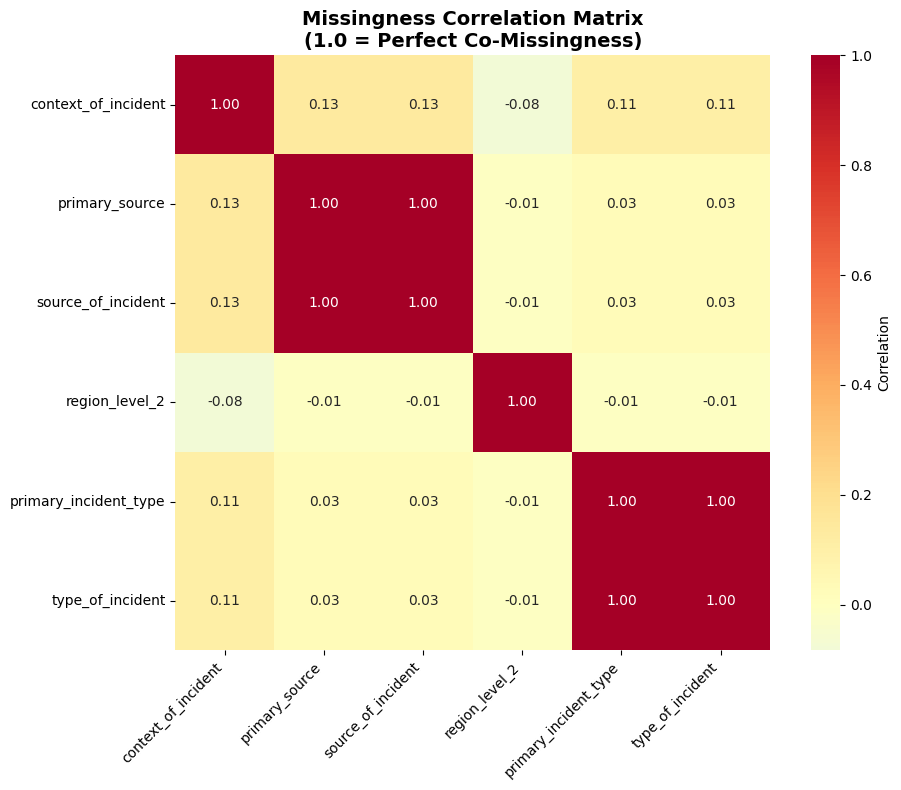


Correlation Matrix:


,context_of_incident,primary_source,source_of_incident,region_level_2,primary_incident_type,type_of_incident
context_of_incident,1.000,0.134,0.134,-0.083,0.109,0.109
primary_source,0.134,1.000,1.000,-0.013,0.028,0.028
source_of_incident,0.134,1.000,1.000,-0.013,0.028,0.028
region_level_2,-0.083,-0.013,-0.013,1.000,-0.010,-0.010
primary_incident_type,0.109,0.028,0.028,-0.010,1.000,1.000
type_of_incident,0.109,0.028,0.028,-0.010,1.000,1.000


In [8]:
# Create correlation matrix of missingness indicators
missing_vars = [
    'context_of_incident', 'primary_source', 'source_of_incident',
    'region_level_2', 'primary_incident_type', 'type_of_incident'
]

missing_matrix = df[missing_vars].isnull().astype(int)
corr_matrix = missing_matrix.corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, square=True, cbar_kws={'label': 'Correlation'})
plt.title('Missingness Correlation Matrix\n(1.0 = Perfect Co-Missingness)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
display(corr_matrix.round(3))

## 9. Comprehensive Visualization

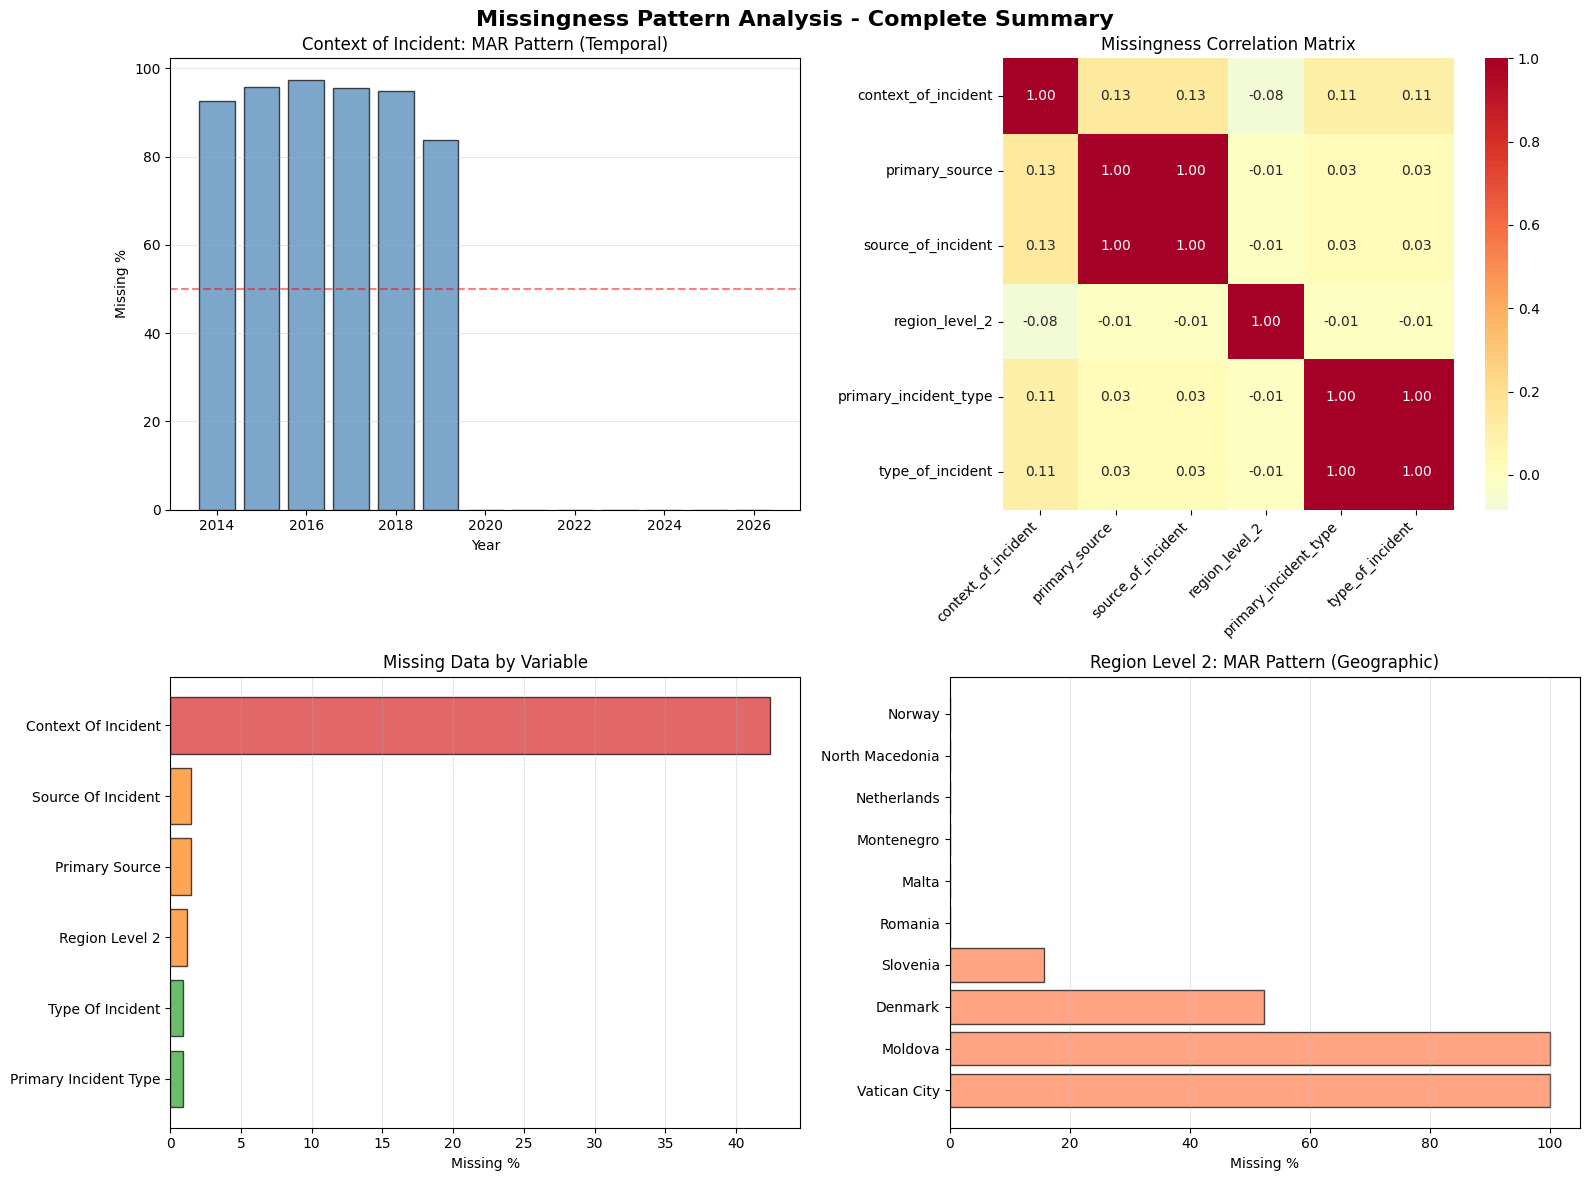

Figure saved as 'missingness_analysis.png'


In [9]:
# Create comprehensive figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Missingness Pattern Analysis - Complete Summary', 
             fontsize=16, fontweight='bold')

# 1. Temporal pattern
ax1 = axes[0, 0]
missing_by_year = df.groupby('year')['context_of_incident'].apply(
    lambda x: x.isnull().mean() * 100
)
ax1.bar(missing_by_year.index, missing_by_year.values, 
        color='steelblue', alpha=0.7, edgecolor='black')
ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('Missing %')
ax1.set_title('Context of Incident: MAR Pattern (Temporal)')
ax1.grid(axis='y', alpha=0.3)

# 2. Correlation heatmap
ax2 = axes[0, 1]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, ax=ax2, square=True)
ax2.set_title('Missingness Correlation Matrix')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Missing percentage by variable
ax3 = axes[1, 0]
missing_pct = (df[missing_vars].isnull().sum() / len(df) * 100).sort_values()
colors = ['#d62728' if x > 40 else '#ff7f0e' if x > 1 else '#2ca02c' 
          for x in missing_pct]
ax3.barh(range(len(missing_pct)), missing_pct.values, 
         color=colors, alpha=0.7, edgecolor='black')
ax3.set_yticks(range(len(missing_pct)))
ax3.set_yticklabels([x.replace('_', ' ').title() for x in missing_pct.index])
ax3.set_xlabel('Missing %')
ax3.set_title('Missing Data by Variable')
ax3.grid(axis='x', alpha=0.3)

# 4. Geographic pattern
ax4 = axes[1, 1]
region_missing_top = df.groupby('country')['region_level_2'].apply(
    lambda x: x.isnull().mean() * 100
).sort_values(ascending=False).head(10)
ax4.barh(range(len(region_missing_top)), region_missing_top.values, 
         color='coral', alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(region_missing_top)))
ax4.set_yticklabels(region_missing_top.index)
ax4.set_xlabel('Missing %')
ax4.set_title('Region Level 2: MAR Pattern (Geographic)')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('missingness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'missingness_analysis.png'")

## 10. Final Classification Report

In [10]:
print("="*80)
print("MISSINGNESS PATTERN CLASSIFICATION")
print("="*80)

report = """

1. CONTEXT_OF_INCIDENT (42.43% missing)
   Pattern: MAR (Missing At Random)
   Evidence: 95-97% missing pre-2020, 0% from 2020+
   Mechanism: Data collection policy change
   
2. PRIMARY_SOURCE & SOURCE_OF_INCIDENT (1.46% missing)
   Pattern: MAR/MNAR
   Evidence: Perfect co-missingness (correlation = 1.0)
   Mechanism: Unknown/sensitive sources not recorded
   
3. PRIMARY_INCIDENT_TYPE & TYPE_OF_INCIDENT (0.88% missing)
   Pattern: MAR/MNAR
   Evidence: Perfect co-missingness (correlation = 1.0)
   Mechanism: Ambiguous incidents hard to classify
   
4. REGION_LEVEL_2 (1.16% missing)
   Pattern: MAR
   Evidence: 100% missing for some countries
   Mechanism: Different administrative structures

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
OVERALL ASSESSMENT:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

❌ NO MCAR: All chi-square tests show p < 0.05
✅ STRONG MAR: Clear dependencies on year, country, incident type
⚠️  POSSIBLE MNAR: Cannot completely rule out for source variables

"""

print(report)

MISSINGNESS PATTERN CLASSIFICATION


1. CONTEXT_OF_INCIDENT (42.43% missing)
   Pattern: MAR (Missing At Random)
   Evidence: 95-97% missing pre-2020, 0% from 2020+
   Mechanism: Data collection policy change
   
2. PRIMARY_SOURCE & SOURCE_OF_INCIDENT (1.46% missing)
   Pattern: MAR/MNAR
   Evidence: Perfect co-missingness (correlation = 1.0)
   Mechanism: Unknown/sensitive sources not recorded
   
3. PRIMARY_INCIDENT_TYPE & TYPE_OF_INCIDENT (0.88% missing)
   Pattern: MAR/MNAR
   Evidence: Perfect co-missingness (correlation = 1.0)
   Mechanism: Ambiguous incidents hard to classify
   
4. REGION_LEVEL_2 (1.16% missing)
   Pattern: MAR
   Evidence: 100% missing for some countries
   Mechanism: Different administrative structures

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
OVERALL ASSESSMENT:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

❌ NO MCAR: All chi-square tests show p < 0.05
✅ STRONG MAR: Clear dependencies on year, country, incident type
⚠️  PO

## 11. Summary Table

In [11]:
summary_data = {
    'Variable': [
        'context_of_incident',
        'primary_source & source_of_incident',
        'primary_incident_type & type_of_incident',
        'region_level_2'
    ],
    'Missing %': ['42.43%', '1.46%', '0.88%', '1.16%'],
    'Pattern': ['MAR', 'MAR/MNAR', 'MAR/MNAR', 'MAR'],
    'Key Evidence': [
        '95-97% missing pre-2020, 0% from 2020+',
        'Perfect co-missingness',
        'Perfect co-missingness',
        '100% missing for some countries'
    ],
    'Recommendation': [
        'Use 2020+ data or include year in models',
        'Treat as "Unknown" category',
        'Manual review of 99 cases',
        'Country-specific handling'
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Variable,Missing %,Pattern,Key Evidence,Recommendation
0,context_of_incident,42.43%,MAR,"95-97% missing pre-2020, 0% from 2020+",Use 2020+ data or include year in models
1,primary_source & source_of_incident,1.46%,MAR/MNAR,Perfect co-missingness,"Treat as ""Unknown"" category"
2,primary_incident_type & type_of_incident,0.88%,MAR/MNAR,Perfect co-missingness,Manual review of 99 cases
3,region_level_2,1.16%,MAR,100% missing for some countries,Country-specific handling


---
## Conclusion

This analysis reveals that the dataset exhibits primarily **MAR (Missing At Random)** patterns, with possible MNAR components in source-related variables. The most significant finding is the dramatic temporal shift in `context_of_incident` collection starting in 2020, which should be considered in any analysis using this variable.